![Black Panther movie poster]
<div>
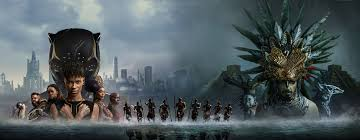
</div>

# Movie Forecasting 
__Sarah Lowing__ DS Flex

Blockbuster movies bring in billions for the studios behind them, and film entertainment is a multi billion dollar industry, particularly when we add in revenue from franchising. But with production costs that can run into the hundreds of millions, studios must be careful about which movies they invest in.  The new media arm of Microsoft, like any other business, should look carefully at the data behind the top office earners in order to make informed decisions about which projects will likely provide the best return.  We can determine this by taking a close look at the genres of movies that are most frequently represented within the top quartile of film's worldwide gross, examining the relationship if (any) between film budgets and earnings, and finally examining when to release the film to maximize profits.  


## Importing and Cleaning Data (EDA)

### Earnings

Let's  start by taking a look at box office eanings.  To do this we'll create a df of box office earnings from Box Office Mojo, or BOM. Then we'll join that information with a table from imdb that catagorizes those movies by genre.  To start, let's import the relevent libraries.

In [1]:
#import relevent libraries
import pandas as pd
import numpy as np
import sqlite3 
import seaborn as sns
import zipfile as zf
import re
import calendar

Now we'll import our box office earnings data from BOM, and sort it by total_gross in descending order. In the following cells we will:
1. Clean the box office gross data 
2. Add foreign and domestic gross together for total_gross
3. Display box office earnings for movies in the top quartile

In [3]:
# Import csv BOM data as df  
df = pd.read_csv("zippedData/bom.movie_gross.csv.gz")

# Clean BOM earnings data
df['domestic_gross'] = df['domestic_gross'].fillna(0)
df['domestic_gross'] = df['domestic_gross'].astype(int)
df['foreign_gross'] = pd.to_numeric(df['foreign_gross'], errors='coerce')
df['foreign_gross'] = df['foreign_gross'].fillna(0)
df['foreign_gross'] = df['foreign_gross'].astype(int)
df['total_gross'] = (df['domestic_gross'] + df['foreign_gross'])

# Return sorted df
earnings_sort = df.sort_values(by=['total_gross'], ascending=False)
earnings_sorted = earnings_sort.reset_index(drop=True)

# Clean titles: drop punctuation and transform to lower case
earnings_sorted['title'] = earnings_sorted['title'].str.lower().str.replace(r'[^\w\s]+', '')
earnings_sorted.head()
earnings_sorted

,title,studio,domestic_gross,foreign_gross,year,total_gross
0,marvels the avengers,BV,623400000,895500000,2012,1518900000
1,avengers age of ultron,BV,459000000,946400000,2015,1405400000
2,black panther,BV,700100000,646900000,2018,1347000000
3,harry potter and the deathly hallows part 2,WB,381000000,960500000,2011,1341500000
4,star wars the last jedi,BV,620200000,712400000,2017,1332600000
...,...,...,...,...,...,...
3382,222,Magn.,400,0,2017,400
3383,news from planet mars,KL,300,0,2016,300
3384,satanic,Magn.,300,0,2016,300
3385,the chambermaid,FM,300,0,2015,300


In [179]:
#how far back do the records go?
print('Earliest record is from:', earnings_sorted['year'].min())
print('Newest record is from:', earnings_sorted['year'].max())
#how many records are in our df?
print('There are ', len(earnings_sorted) ,' records in this df')

Earliest record is from: 2010
Newest record is from: 2018
There are  3387  records in this df


### Establishing Genres
Now that we have our earnings data, let's check out the genres of those movies using the imdb database.  

In [4]:
#connect to imdb sql db
conn = sqlite3.connect("im.db")
cur = conn.cursor()

In [5]:
#create df showing genres
genres_all = pd.read_sql("SELECT * FROM movie_basics", conn)

In [182]:
#how far back do the records go?
print('Earliest record is from:', genres_all['start_year'].min())
print('Newest record is from:', genres_all['start_year'].max())
#how many records are in our df?
print('There are ', len(genres_all) ,' records in this df')

Earliest record is from: 2010
Newest record is from: 2115
There are  146144  records in this df



There's definitely no movies from 2115 yet...
We'll need to see how current these records are a different way

In [190]:
by_year= genres_all.sort_values(by=['start_year'], ascending=False)
by_year.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
89506,tt5174640,100 Years,100 Years,2115,NaN,Drama
96592,tt5637536,Avatar 5,Avatar 5,2027,NaN,"Action,Adventure,Fantasy"
2949,tt10300398,Untitled Star Wars Film,Untitled Star Wars Film,2026,NaN,Fantasy
52213,tt3095356,Avatar 4,Avatar 4,2025,NaN,"Action,Adventure,Fantasy"
105187,tt6149054,Fantastic Beasts and Where to Find Them 5,Fantastic Beasts and Where to Find Them 5,2024,NaN,"Adventure,Family,Fantasy"


It looks like this database also contains entries for upcoming projects. 

In [6]:
#rename column to make compatable with top_earners and drop unneccessary columns
#clean "title"
genres_all.rename(columns={'primary_title':'title'}, inplace=True)
genres_all.drop(columns = ['movie_id','original_title', 
                           'start_year','runtime_minutes'], inplace=True)
genres_all['title'] = genres_all['title'].str.lower().str.replace(r'[^\w\s]+', '')
genres_all.head()

,title,genres
0,sunghursh,"Action,Crime,Drama"
1,one day before the rainy season,"Biography,Drama"
2,the other side of the wind,Drama
3,sabse bada sukh,"Comedy,Drama"
4,the wandering soap opera,"Comedy,Drama,Fantasy"


In [7]:
#merge earnings and genres dfs
earnings_and_genre= earnings_sorted.merge(genres_all, on="title", how='left')
earnings_and_genre.head()

,title,studio,domestic_gross,foreign_gross,year,total_gross,genres
0,marvels the avengers,BV,623400000,895500000,2012,1518900000,NaN
1,avengers age of ultron,BV,459000000,946400000,2015,1405400000,"Action,Adventure,Sci-Fi"
2,black panther,BV,700100000,646900000,2018,1347000000,"Action,Adventure,Sci-Fi"
3,harry potter and the deathly hallows part 2,WB,381000000,960500000,2011,1341500000,"Adventure,Drama,Fantasy"
4,star wars the last jedi,BV,620200000,712400000,2017,1332600000,"Action,Adventure,Fantasy"


__Checking For Nan Values and Duplicates__

We can see that despite cleaning titles, there's still some NaN values in genres, including two in our top 20 grossing films.  Due to naming convention mismatches we'll focus on getting those values for the top 20 films and leaving the remainder.  We can also see there are some duplicates in our data, we'll go ahead and drop those as well.

In [8]:
# It looks like a significant number of , but still fairly small number of our values are NaN. 
# We'll focus on filling in the data for the top 20 films

#check for duplicates
dups = earnings_and_genre.duplicated(subset=['title'])
# drop duplicates
earnings_and_genre.drop_duplicates(subset=['title'], keep='first', inplace=True)

len(earnings_and_genre)
print("TOTAL ROWS:", len(earnings_and_genre))
print('-------------------')
print("NaN VALUES:", earnings_and_genre['genres'].isnull().sum())


TOTAL ROWS: 3386
-------------------
NaN VALUES: 648


In [9]:
# Fill in values for 'genre' for the 10 highest grossing films:
# First we'll locate the genre for the film

#genres_all.loc[genres_all['title'].str.contains('avengers')]
#genres_all.loc[genres_all['title'].str.contains('beauty and the beast')]

# Next we replace NaN with the genres
earnings_and_genre.loc[earnings_and_genre['title']== 'marvels the avengers', 'genres'] ='Action,Adventure,Sci-Fi'
earnings_and_genre.loc[earnings_and_genre['title']==  'beauty and the beast 2017','genres'] = 'Family,Fantasy,Musical'



In [9]:
earnings_and_genre.head()

,title,studio,domestic_gross,foreign_gross,year,total_gross,genres
0,marvels the avengers,BV,623400000,895500000,2012,1518900000,"Action,Adventure,Sci-Fi"
1,avengers age of ultron,BV,459000000,946400000,2015,1405400000,"Action,Adventure,Sci-Fi"
2,black panther,BV,700100000,646900000,2018,1347000000,"Action,Adventure,Sci-Fi"
3,harry potter and the deathly hallows part 2,WB,381000000,960500000,2011,1341500000,"Adventure,Drama,Fantasy"
4,star wars the last jedi,BV,620200000,712400000,2017,1332600000,"Action,Adventure,Fantasy"


### Movie Release Dates

Now that we have our earnings and genres established, we'll prepare our data from The Numbers to look at how the timing of a movie's release might influence earnings in the upcoming Analysis section.

In [10]:
#open The Numbers data as n
n = pd.read_csv("zippedData/tn.movie_budgets.csv.gz")
n.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [102]:
#look at the size of the file
len(n)

5782

In [11]:
#drop unneeded columns
release= n.drop(['id', 'domestic_gross', 'production_budget',
                 'movie'], axis=1)

In [12]:
#change worldwide_gross from str to int
release['worldwide_gross'] = release['worldwide_gross'].str.replace('[^\w\s]','')
release['worldwide_gross'] = release['worldwide_gross'].astype(int)

In [13]:
#change date str to datetime object
release['release_date'] = pd.to_datetime(release['release_date'])

In [33]:
#group by release date and earnings and sort by highest earning date
release.groupby('release_date')['worldwide_gross'].sum().sort_values(ascending = False)
#sort by release date
release['year'] = release['release_date'].dt.year
release['month'] = release['release_date'].dt.month#_name()
release.sort_values(by = 'worldwide_gross',
                    ascending = False).head()


,release_date,worldwide_gross,month,year
0,2009-12-18,2776345279,12,2009
42,1997-12-19,2208208395,12,1997
5,2015-12-18,2053311220,12,2015
6,2018-04-27,2048134200,4,2018
33,2015-06-12,1648854864,6,2015


In [17]:
#lets see just how much money these films bring in per year
years=release.groupby(release['year']).sum()
#there's records for the last 96 years, let's just select the last 30
last_30= years[64:94]
#and make sure our df is what we expect
last_30.head()

,worldwide_gross
year,
1989,2652711244
1990,4037229644
1991,3611227219
1992,4027022156
1993,4386461109


>Ok! This data will be very effective in our presentation to demonstrate the earning potential of the film industry. Let's convert it to a bargraph for the non-technical presentation


''

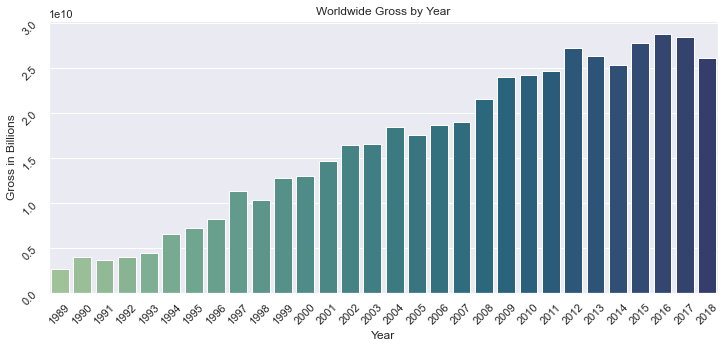

In [178]:
sns.set(rc={"figure.figsize":(12,5)})
L30= sns.barplot(data=last_30, x=last_30.index, y='worldwide_gross', palette="crest")
L30.tick_params(labelrotation=45)
L30.set_title('Worldwide Gross by Year')
L30.set(xlabel="Year", ylabel="Gross in Billions")

;

> Now that we have all our data prepared we can dig into our analysis

## Analysis

First we'll look at the distribution of genres over our entire dataset.  Next we'll take a more granular view of the top quartile of earnings; we'll look at the distribution of genres for that subset, and seeing if there are any genres that are represented disproportionately in the top quartile films.  Then we'll look at the correlation of film budgets to earnings.  Finally we'll analyze release date information to see if there's an optimal month for release dates to maximize box office earnings.

### Distribution of Genres

In [15]:
#Split csv genres into seperate categories
genres_split= earnings_and_genre['genres'].str.split(',', 
        expand=True).stack().reset_index(level=1, drop=True)

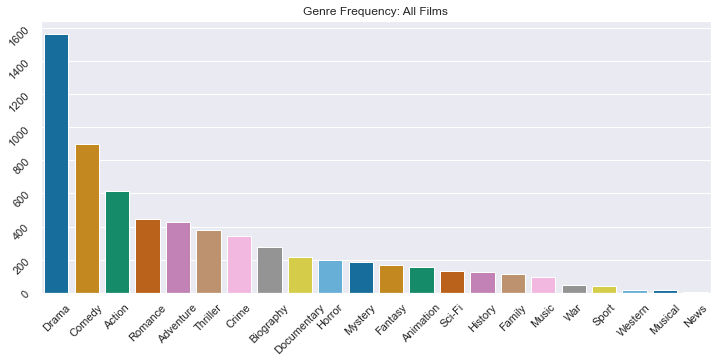

In [16]:
#genres_count=
genres_list= genres_split.value_counts()


sns.set(rc={"figure.figsize":(12,5)})
p= sns.barplot(x=genres_list.index, y=genres_list.values, palette="colorblind")
p.tick_params(labelrotation=45)
p.set_title('Genre Frequency: All Films');



>Now that we've seen the distibution of genres for all our movies, let's take a closer look at the top quartile of films by total_gross


In [17]:
#Get the top quartile of gross earnings and store as top_earners:
top_earners = earnings_and_genre[earnings_and_genre['total_gross'] >\
                                 earnings_and_genre['total_gross'].quantile(0.75)]
len(top_earners)

847

In [18]:
#explode genres
genres_top_earners= top_earners['genres'].str.split(',', 
        expand=True).stack().reset_index(level=1, drop=True)

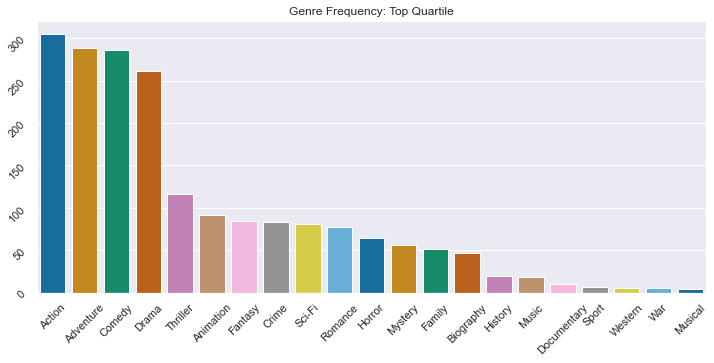

In [19]:
#plot genres
genres_top_earners_list= genres_top_earners.value_counts()
sns.set(rc={"figure.figsize":(12,5)})
t= sns.barplot(x=genres_top_earners_list.index, y=genres_top_earners_list.values, palette="colorblind")
t.tick_params(labelrotation=45)
t.set_title('Genre Frequency: Top Quartile');


>There's a rather significant change in the genres of our top films.  We can see that while most films produced are __dramas__, that the vast majority of top earning films tend to be __action__.  It's clear that there's a significant market for films that excite.  Lets take a look at just the top 20 grossing films to get an even closer view of which genres are represented most frequently there.  


In [20]:
#get top 20 films and store as top_20
top_20 = top_earners.head(20)
#split genres
t_20= top_20['genres'].str.split(',', 
        expand=True).stack().reset_index(level=1, drop=True)

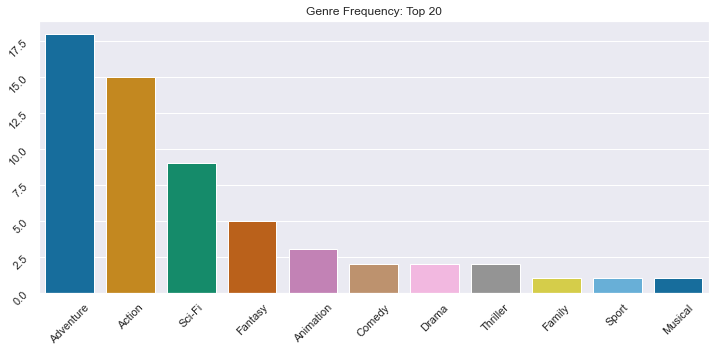

In [21]:
#plot genres
t_20_list = t_20.value_counts()
sns.set(rc={"figure.figsize":(12,5)})
t20= sns.barplot(x=t_20_list.index, y= t_20_list.values, palette="colorblind")
t20.tick_params(labelrotation=45)
t20.set_title('Genre Frequency: Top 20');

We should not that films often have multiple genres assigned to them, so we will see a greater number of films listed than our top 20 because many of them have multiple genres. We can observe that the top grossing films heavily skew towards __Action/Adventure and Sci-Fi/Fantasy__.  Is this just a recent phenomena, or does this trend have longetivity?  Let's look at the dates that our top 20 films have been released.

In [22]:
top_20_release_dates= top_20[['title','year']].copy()
#new = old[['A', 'C', 'D']].copy()
top_20_release_dates.head()

,title,year
0,marvels the avengers,2012
1,avengers age of ultron,2015
2,black panther,2018
3,harry potter and the deathly hallows part 2,2011
4,star wars the last jedi,2017


In [19]:
print('The oldest film in the top 20 grossing films is:', top_20_release_dates['year'].min())

The oldest film in the top 20 grossing films is: 2010


In [20]:
top_earners_release_dates= top_earners[['title','year']].copy()
print('The oldest film in the top quartile of worldwide earnings is:',
      top_earners_release_dates['year'].min())

The oldest film in the top quartile of worldwide earnings is: 2010


>OK! This tells us it's not just a passing trend, Action/Adventure films with a Sci-Fi/Fantasy twist have been big box office winners for a good long time.

### Earnings by Genre

We've seen which genres are most prevelant, but we still need to see how genre impacts earnings.  Are there certain genres which have a stronger box office draw?  We'll expect to see a larger portion of earnings for Action/Adventure films, because they have a larger share of the market in our top quartile grossing films.  Here we're going to want to explode the list of genres once againso that each genre is listed individually.We'll then use a plot to visualize earnings per genre.

In [36]:
#clean df so only title, total_gross, and genres remain
clean = top_earners.drop(['studio','domestic_gross',
                          'foreign_gross', 'year'],axis=1)

#create individual entries for each genre
genres_te = top_earners['genres'].str.split(',',
            expand=True).stack().reset_index(level=1, drop=True)

#merge exploded genres with movie and total_gross and sort by total_gross
df4=clean.merge(genres_te.to_frame(name='genre'),
                left_index=True, right_index=True)
df4.drop(columns='genres', inplace=True)
#did it work?  
df4.head()

,title,total_gross,genre
0,marvels the avengers,1518900000,Action
0,marvels the avengers,1518900000,Adventure
0,marvels the avengers,1518900000,Sci-Fi
1,avengers age of ultron,1405400000,Action
1,avengers age of ultron,1405400000,Adventure


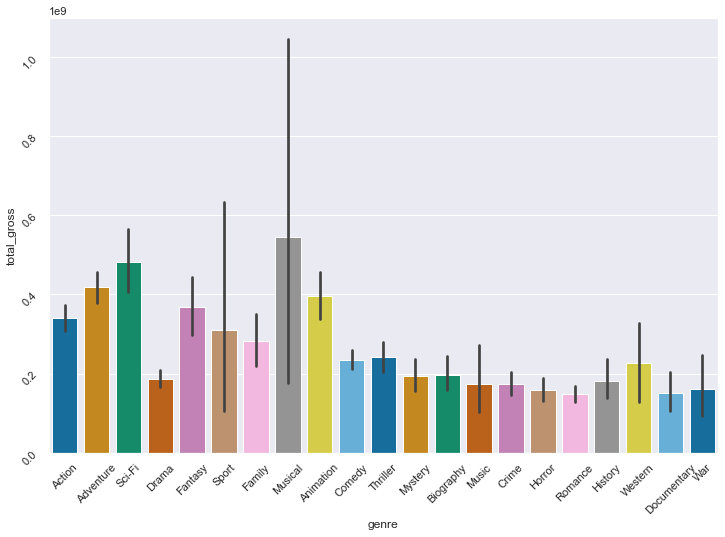

In [37]:
sns.set(rc={"figure.figsize":(12,8)})
total_gross_bar=sns.barplot(x='genre', y='total_gross',
             data=df4, palette="colorblind")
total_gross_bar.tick_params(labelrotation=45)

This doesn't look quite right- we would have expected to see action adventure taking the lead, but Musicals are looking like they are a better bet.  Let's take a closer look to make sure our assumption was true.

In [144]:
df4.groupby('genre').sum().sort_values(by=['total_gross'], ascending=False)

,total_gross
genre,
Adventure,120270874293
Action,103807975796
Comedy,67015020394
Drama,48590873797
Sci-Fi,38950905999
Animation,36141128096
Fantasy,30937638998
Thriller,27929399998
Family,14372299999


Ok, we can see clearly that action/adventure is indeed in the lead, let's try another plot.

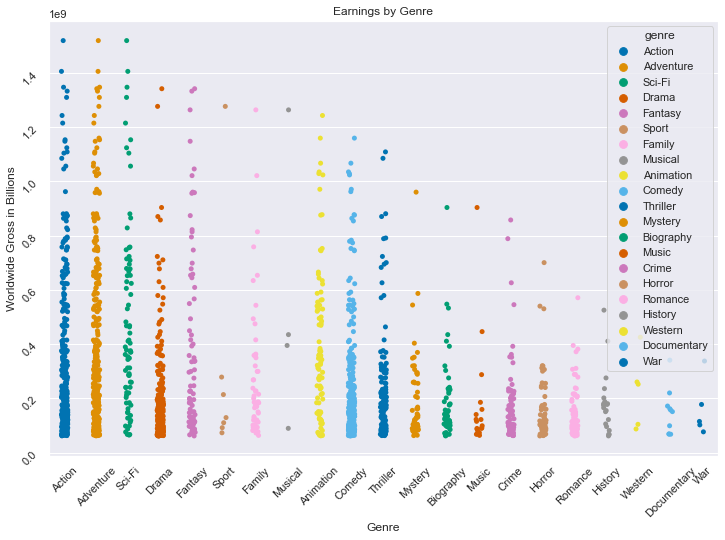

In [28]:
#plot df4 as stripplot
sns.set(rc={"figure.figsize":(12,8)})
total_gross_genres=sns.stripplot(x='genre', y='total_gross', hue='genre',
             data=df4, palette="colorblind")


total_gross_genres.set(xlabel="Genre", ylabel="Worldwide Gross in Billions")
total_gross_genres.tick_params(labelrotation=45)
total_gross_genres.set_title('Earnings by Genre');


>We can see that our hypothesis is validated- Action and Adventure films are by far the highest earning films.  But producing those kinds of films requires significant capital investment.  Are they really worth it?  Let's examine budgets VS Earnings to find out. 

### Comparing Budgets vs. Earnings

Now that we've seen what genres of movies are top earners, let's look to see if there's a correlation between a big budget and big profits.  Our first step will be to open the csv file from The Numbers to view our movie titles and their budgets.

In [18]:
#clean N data to only show budget and gross
#drop unneeded columns
budget= n.drop(['id', 'release_date', 'domestic_gross'], axis=1)
budget.head()

,movie,production_budget,worldwide_gross
0,Avatar,"$425,000,000","$2,776,345,279"
1,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$1,045,663,875"
2,Dark Phoenix,"$350,000,000","$149,762,350"
3,Avengers: Age of Ultron,"$330,600,000","$1,403,013,963"
4,Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$1,316,721,747"


In [19]:
#clean column values
budget['production_budget'] = budget['production_budget'].str.replace('[^\w\s]','')
budget['production_budget'] = budget['production_budget'].astype(int)
budget['worldwide_gross'] = budget['worldwide_gross'].str.replace('[^\w\s]','')
budget['worldwide_gross'] = budget['worldwide_gross'].astype(int)


In [20]:
#sort by top gross and extract top quartile earners
budget_sorted = budget.sort_values(by=['worldwide_gross'], ascending=False)
budget_sorted = budget_sorted.reset_index(drop=True)
bstq= budget_sorted[budget_sorted['worldwide_gross'] > budget_sorted['worldwide_gross'].quantile(0.75)]
#prove it worked
bstq.head()

,movie,production_budget,worldwide_gross
0,Avatar,425000000,2776345279
1,Titanic,200000000,2208208395
2,Star Wars Ep. VII: The Force Awakens,306000000,2053311220
3,Avengers: Infinity War,300000000,2048134200
4,Jurassic World,215000000,1648854864


In [ ]:
bstq['net_income']= bstq['worldwide_gross'] - bstq['production_budget']
bstq.sort_values(by=['net_income'], ascending=False)



Now that we've got our budgets vs. earnings df, lets look at the correlation between budgets and worldwide_gross for all films, and for films in our top quartile.




In [524]:
print("Correlation of Budget to Worldwide Gross: All films \n\n",  budget_sorted.corr())
print('\n-----------------------------------------\n')
print('Correlation of Budget to Worldwide Gross: Top Quartile \n\n', bstq.corr())


Correlation of Budget to Worldwide Gross: All films 

                    production_budget  worldwide_gross
production_budget           1.000000         0.748306
worldwide_gross             0.748306         1.000000

-----------------------------------------

Correlation of Budget to Worldwide Gross: Top Quartile 

                    production_budget  worldwide_gross  net_income
production_budget           1.000000         0.628690    0.457357
worldwide_gross             0.628690         1.000000    0.979092
net_income                  0.457357         0.979092    1.000000




>We can see that there is indeed a strong correlation between production budget and total gross for all films, and a moderate to strong correlation in the top quartile of earners.  Let's see what that looks like using a scatterplot.



''

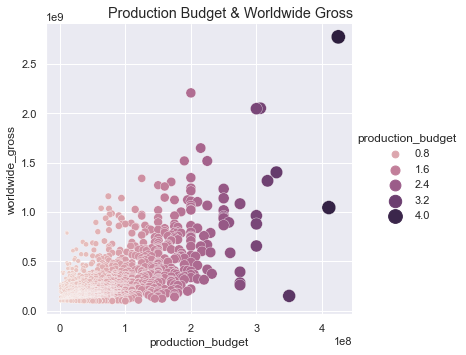

In [90]:
g = sns.relplot(
                data = bstq,
                x = "production_budget", y = "worldwide_gross",
                hue = "production_budget", size = "production_budget",
                sizes = (10, 200),
                )
g.fig.suptitle('Production Budget & Worldwide Gross')
g.set(xscale = "linear", yscale = "linear")
;

So far we've been looking at box office returns without taking into account that larger budgets dip into earnings.  Let's look at what the net income from these films would be.

In [152]:
budget['net']=budget['worldwide_gross'] - budget['production_budget']
budget[budget['net']< 0] = 0
net_earnings= budget.sort_values(by='net', ascending=False)
net_earnings.head(20)

,movie,production_budget,worldwide_gross,net
0,Avatar,425000000,2776345279,2351345279
42,Titanic,200000000,2208208395,2008208395
6,Avengers: Infinity War,300000000,2048134200,1748134200
5,Star Wars Ep. VII: The Force Awakens,306000000,2053311220,1747311220
33,Jurassic World,215000000,1648854864,1433854864
66,Furious 7,190000000,1518722794,1328722794
26,The Avengers,225000000,1517935897,1292935897
260,Harry Potter and the Deathly Hallows: Part II,125000000,1341693157,1216693157
41,Black Panther,200000000,1348258224,1148258224
112,Jurassic World: Fallen Kingdom,170000000,1305772799,1135772799


With just a cursory glance we can see that many of the top 20 earningest films are still action adventure.  But let's prove it by joining the net_earnings df with genres one more time.

In [153]:
#first we need to clean the 'movie' titles and change the name of the column for our merge
net_earnings['title'] = net_earnings['movie'].str.lower().str.replace(r'[^\w\s]+', '')


In [158]:
#next we'll join it with the genres information from imdb
net_and_genre= net_earnings.merge(genres_all, on="title", how='left')
net_and_genre.drop(columns = 'movie', inplace=True)
net_and_genre.head()

,production_budget,worldwide_gross,net,title,genres
0,425000000,2776345279,2351345279,avatar,Horror
1,200000000,2208208395,2008208395,titanic,Adventure
2,200000000,2208208395,2008208395,titanic,Family
3,300000000,2048134200,1748134200,avengers infinity war,"Action,Adventure,Sci-Fi"
4,306000000,2053311220,1747311220,star wars ep vii the force awakens,NaN


In [167]:
#check for duplicates
dups = net_and_genre.duplicated(subset=['title'])
# drop duplicates
net_and_genre.drop_duplicates(subset=['title'], keep='first', inplace=True)
#did it work?
net_and_genre.head()

,production_budget,worldwide_gross,net,title,genres
0,425000000,2776345279,2351345279,avatar,Horror
1,200000000,2208208395,2008208395,titanic,Adventure
3,300000000,2048134200,1748134200,avengers infinity war,"Action,Adventure,Sci-Fi"
4,306000000,2053311220,1747311220,star wars ep vii the force awakens,NaN
5,215000000,1648854864,1433854864,jurassic world,"Action,Adventure,Sci-Fi"


In [162]:
print("TOTAL ROWS:", len(net_and_genre))
print('-------------------')
print("NaN VALUES:", net_and_genre['genres'].isnull().sum())

TOTAL ROWS: 3612
-------------------
NaN VALUES: 2119


There's a lot of missing values here.  Because we are mostly concerned with double checking our previous assertation that Action/Adventure films offer our best bet for the largest ROI, even after their costly budgets we're going to map out the data we do have rather than dig deeper into filling in our NaN values.

In [164]:
#Split csv genres into seperate categories
ng_split= net_and_genre['genres'].str.split(',', 
        expand=True).stack().reset_index(level=1, drop=True)

0          Horror
1       Adventure
3          Action
3       Adventure
3          Sci-Fi
          ...    
4483        Drama
4483      Fantasy
4483      Mystery
4484        Drama
4487        Drama
Length: 3529, dtype: object

In [174]:
#merge exploded genres with net df and sort by total_gross
df5=net_and_genre.merge(ng_split.to_frame(name='genre'),
                left_index=True, right_index=True)
df5.drop(columns='genres', inplace=True)

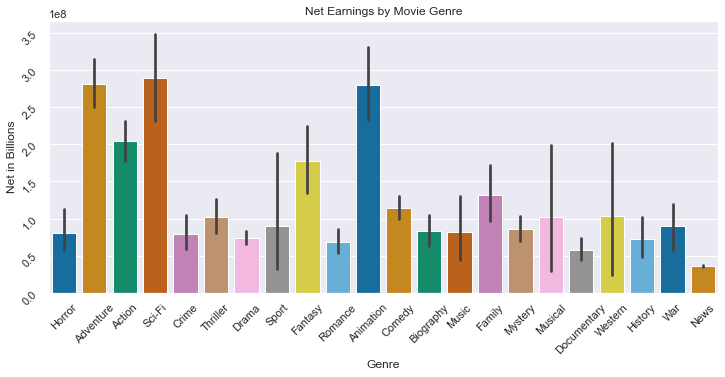

In [177]:
#turn df into bargraph
netb = sns.barplot(data = df5,
                x = "genre",
                y = "net",
                palette="colorblind")
netb.tick_params(labelrotation=45)
netb.set(xlabel="Genre", ylabel="Net in Billions")
netb.set_title('Net Earnings by Movie Genre');

There's definitely a case to be made that even after accounting for a large budget, Action/Adventure films with a Fantasy/Sci-Fi bend have strongest ROI potential.  This new data also shows that Animated films are also a good bet.

### Release Dates and Earnings

Now let's dive back into movie release times to see if there's a relationship between release month and worldwide gross.  We'll look at the mean earnings per month to do this.

In [34]:
month_sum = release.groupby('month')['worldwide_gross'].sum()
month_sorted = month_sum.sort_values(ascending=False)
month_sorted

month
12    75761412153
6     68268531657
5     66043077615
11    65970430672
7     62023990453
3     37897684431
8     30245291880
10    28343193867
2     28045454121
4     27203797390
9     23019987786
1     16157646936
Name: worldwide_gross, dtype: int64

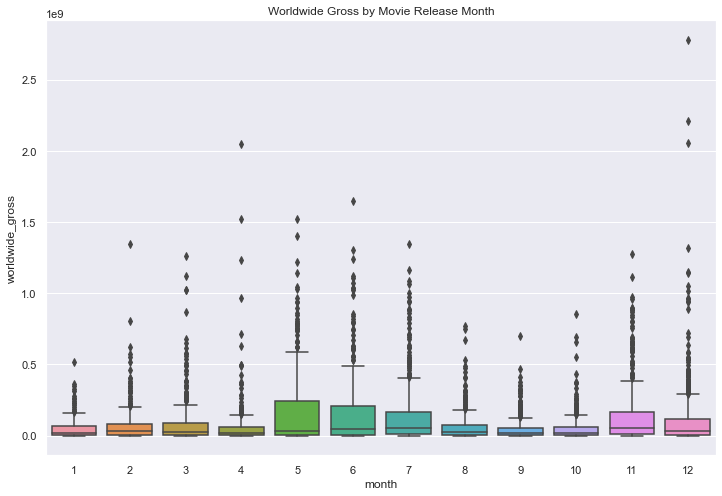

In [90]:
#and now for better clarity let's look at that as a plot
months=release.groupby('month')['worldwide_gross']
m = sns.boxplot(data = release,
                   x = "month",
                   y = "worldwide_gross")


m.set_title('Worldwide Gross by Movie Release Month');

> And now as a barplot for our presentation

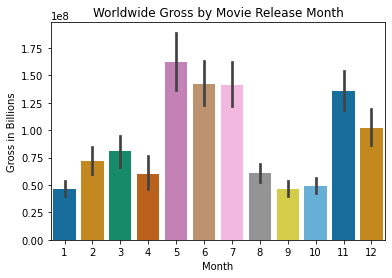

In [40]:
#plot worldwide gross by release months
mo = sns.barplot(data = release,
                x = "month",
                y = "worldwide_gross",
                palette="colorblind")

mo.set(xlabel="Month", ylabel="Gross in Billions")
mo.set_title('Worldwide Gross by Movie Release Month');

We can see that May is by far the best month to release a new film, and that early summer in general is the time newly released movies are most likely to have the biggest return in box office gross worldwide.

# Recommendations




##### 1. Invest in Action/Adventure Films
There has been a historically strong market for Action/Adventure films that remains vital.  
##### 2. Spend Big
Although investing in such films remains risky- there are significant cost outlays to produce these types of films- however those risks are very often rewarded with strong box office showings as the correlation between budget and worldwide gross demonstated.  
##### 3. Release Films in May 
Additionally, the film division should time releases for May to maximize ticket sales.  

# Conclusion 

Now that we have a clear understanding of the historical trends for blockbuster films, what further inquiries do we have?  And how can Microsoft set itself apart in a field of stiff competition?

##### Research Streaming Services
It would be worth taking the time to research live streaming ROI to weigh the possible advantages of capturing both theater and home streaming income.  Theater income is just starting to recover from it's covid induced dip, and income from streaming coud be a excellent way to insulate the media division from future losses as home viewing theaters become more popular.  
##### Diversify Casts
While a large number of the most recent blockbuster films can be classified as Action/Adventure films with a Sci-Fi/Fantasy spin, there is a largely untapped market to produce these kinds of epic sagas with more diverse cast members. As the recent success of movies like "Black Panther" demonstrate, viewers are hungry for films that include characters that better represent the diverse world we live in.  Microsoft should explore licensing rights not just for diverse heros in comic books, but also novels by authors like Octavia Butler and NK Jemison who have proven in the notoriously difficult market of publishing that they can maintain a significant readership.
